In [14]:
tickers = ["AMZN", "TSLA", "BABA", "HD", "TM", "NKE", "MCD", "LOW", "SBUX", "JD", "PDD", "BKNG", "GM", "MELI", "TJX", "NIO", "F", "LULU", "HMC", "CMG"]

In [15]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

(1704, 20, 14, 1)
(426, 20, 14, 1)
(1704, 3)
(426, 3)

Train labels:
[2 1 2 ... 1 2 2]
Test labels:
[2 2 2 1 0 2 2 1 2 2 0 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 2 2 2 2 1 2 2 1 2 1 1
 2 2 1 2 0 1 0 1 1 1 2 1 1 2 0 2 1 2 2 2 2 2 1 2 1 2 1 1 1 2 2 1 1 2 2 2 2
 1 2 2 1 2 1 1 1 1 1 2 1 1 1 2 1 2 2 1 1 1 2 1 1 1 2 0 0 2 2 2 2 2 2 2 1 2
 0 2 2 2 1 2 1 2 1 1 2 2 1 1 1 0 1 1 1 2 2 1 2 1 2 1 1 2 2 1 0 2 1 1 1 1 2
 0 1 2 0 2 2 2 1 2 1 2 2 1 1 1 2 2 2 2 1 2 2 0 1 1 2 2 0 2 2 1 1 2 1 2 1 2
 0 2 1 1 1 2 1 1 1 2 2 2 2 2 1 0 2 1 1 2 1 2 2 2 2 2 1 1 2 1 2 1 2 2 1 0 1
 2 2 2 1 1 2 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1 2 1 1 2 1 0 1 1 1 1 1 2 1 1 1 2
 0 1 2 2 2 1 1 1 2 1 2 2 2 2 1 1 2 2 2 1 2 1 2 2 1 2 1 2 2 1 2 1 2 2 2 2 2
 1 2 0 2 1 1 2 2 2 1 2 2 1 1 1 1 2 2 2 1 1 1 1 2 2 1 1 2 2 1 2 0 2 2 2 1 2
 1 2 2 2 2 2 2 1 2 2 2 2 1 2 2 1 2 1 2 2 1 2 2 2 1 2 1 1 1 1 2 1 1 1 1 2 2
 1 2 1 2 1 2 1 1 2 2 2 2 2 1 2 2 2 0 2 2 2 1 2 2 1 1 2 1 2 1 1 0 2 2 1 1 2
 2 2 2 1 1 2 2 0 1 1 1 1 2 2 2 1 1 2 2]


(1704, 3)
(426, 3)


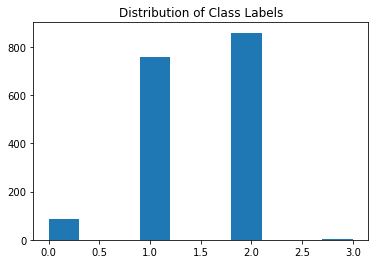

In [254]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy import stats

IMG_SIZE = 20

for ticker in tickers:
    data = pd.read_csv(f'./data_with_labels/{ticker}_with_labels.csv')
    features, labels = data.drop(['policy', 'Date'], axis=1), data['policy']

    if (ticker == "AMZN"):
        X = features.to_numpy()
        y = labels.to_numpy()
    else:
        X_new = features.to_numpy()
        y_new = labels.to_numpy()
        X = np.concatenate((X, X_new), axis=0)
        y = np.concatenate((y, y_new), axis=0)

# center each feature with 0 mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# reshape the data into 2D images 
num_timestamps = X.shape[0]
img_size = IMG_SIZE
num_imgs = num_timestamps // img_size
X = X[: num_imgs * img_size, :]
y = y[: num_imgs * img_size]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(int(.2 * num_imgs)/num_imgs), shuffle=True)

X_train = np.reshape(X_train, (-1, img_size, 14, 1))
X_test = np.reshape(X_test, (-1, img_size, 14, 1))

y_train_cat = np.round(np.median(np.reshape(y_train, (-1, img_size)), axis=1)).astype(int)
y_test_cat = np.round(np.median(np.reshape(y_test, (-1, img_size)), axis=1)).astype(int)

enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(y_train_cat[:, np.newaxis]).toarray()
y_test = enc.fit_transform(y_test_cat[:, np.newaxis]).toarray()

# We don't have enough data labeled with policy 3
if (y_train.shape[1] > 3):
    keep_inds = np.argwhere(y_train[:,3] == 0)
    y_train = y_train[keep_inds, :][:, 0, :]
    y_train = y_train[:, :3]
    X_train = X_train[keep_inds][:, 0, :, :]
if (y_test.shape[1] > 3):
    keep_inds = np.argwhere(y_test[:,3] == 0)
    y_test = y_test[keep_inds, :][:, 0, :]
    y_test = y_test[:, :3]
    X_test = X_test[keep_inds][:, 0, :, :]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print("\nTrain labels:")
print(y_train_cat)
print("Test labels:")
print(y_test_cat)
print("\n")

print(y_train.shape)
print(y_test.shape)

h = plt.hist(y_train_cat)
txt = plt.title("Distribution of Class Labels")

In [255]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(img_size, 14, 1)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(16, (2, 2), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3))
    return model

In [256]:
model = create_model()
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, 
                    validation_data=(X_test, y_test))

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 18, 12, 8)         80        
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 6, 4, 8)           0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 5, 3, 16)          528       
_________________________________________________________________
flatten_26 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 10)                2410      
_________________________________________________________________
dense_53 (Dense)             (None, 3)                 33        
Total params: 3,051
Trainable params: 3,051
Non-trainable params: 0
___________________________________________________

14/14 - 0s - loss: 1.1654 - accuracy: 0.5258


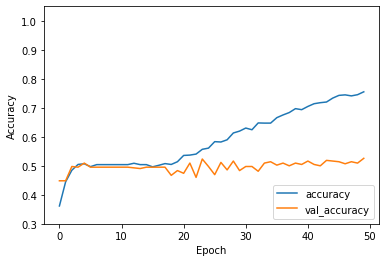

In [257]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3,1.05])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)